# Text Classification

Text classification for Sentiment Analysis is one of the most common tasks in natural language processing. It consists in computationally analysing text messages and tell whether the underlying sentiment is positive, negative our neutral. Let's create a simple text classifier using tweets from the first 2016 GOP Presidential Debate available online [kaggle](https://www.kaggle.com/ngyptr/python-nltk-sentiment-analysis/data). 

In [69]:
import pandas as pd # import pandas
tweets_data_df = pd.read_csv("../../datasets/Sentiment.csv") # load data
tweets_data_df = tweets_data_df.reset_index()

## Exploratory Data Analysis
Let's take a look at the content of this dataset.

In [70]:
pd.set_option("max_rows", 5)  # only display up to 5 rows when printing dataframes (reduce visual clutter)
tweets_data_df

,index,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,0,1,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6578,None of the above,1.0000,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,1,2,Scott Walker,1.0000,yes,1.0000,Positive,0.6333,None of the above,1.0000,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13869,13869,13870,Donald Trump,1.0000,yes,1.0000,Negative,1.0000,Women's Issues (not abortion though),0.9202,...,yes,149,NaN,Women's Issues (not abortion though),RT @JRehling: #GOPDebate Donald Trump says tha...,NaN,2015-08-07 09:54:04 -0700,629697023663546368,NaN,NaN
13870,13870,13871,Ted Cruz,0.9242,yes,0.9614,Positive,0.9614,None of the above,0.9242,...,yes,65,Positive,NaN,RT @Lrihendry: #TedCruz headed into the Presid...,NaN,2015-08-06 18:22:27 -0700,629462573641920512,"San Antonio, TX",Central Time (US & Canada)


How are the sentiment labels distributed? How much can we trust on those labels?

Text(0,0.5,'Confidence')

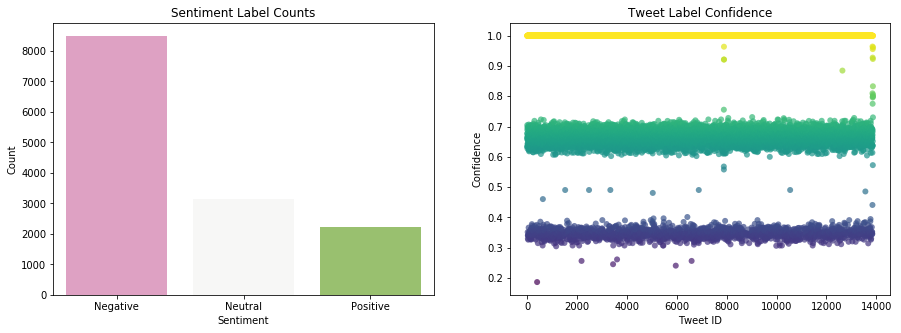

In [71]:
import seaborn as sns                  # import seaborn for visualization
import matplotlib.pyplot as plt

# bar chart to show the number of tweets tagged as Positive/Neutral/Negative
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x="sentiment", order=["Negative","Neutral","Positive"], data=tweets_data_df, palette="PiYG", ax=ax1)
ax1.set_title("Sentiment Label Counts")
ax1.set_xlabel("Sentiment")
ax1.set_ylabel("Count")

# scatter plot showing the labels confidence per tweet.
# usefull for discarding unreliable tweets. 
sns.scatterplot(x="id", y="sentiment_confidence", hue="sentiment_confidence", palette="viridis",
                sizes=(5,), linewidth=0, alpha=0.7,legend=False, data=tweets_data_df, ax=ax2)
ax2.set_title("Tweet Label Confidence")
ax2.set_xlabel("Tweet ID")
ax2.set_ylabel("Confidence")

## Data Filtering
Based on the figures above, we decide to filter the data we will use in order to build our classifier and keep only `text` and `sentiment` columns. Adittionally, we remove rows with `sentiment_confidence` below 0.5. Since we will be performing binary classification, we remove `Neutral` tweets and replace `Negative` and `Positive` strings with integers labels. Finally, a large unbalance in the number of labeled data for a given category can severely affect the performance of a classiier. Therefore, we randomly remove negative tweets to match the number of positive samples in or data set.

In [72]:
import numpy as np

# keeping only rows with sentiment_confidence >0.5
tweets_data_df = tweets_data_df[tweets_data_df["sentiment_confidence"]>0.5] 

# remove random negative tweets
total_negative = tweets_data_df["sentiment"].value_counts()["Negative"] # count positive and negative rows
total_positive = tweets_data_df["sentiment"].value_counts()["Positive"]
to_remove = np.random.choice(tweets_data_df[tweets_data_df['sentiment']=="Negative"].index, # select random rows
                             size=total_negative-total_positive,
                             replace=False)
tweets_data_df = tweets_data_df.drop(to_remove) # remove

# keeping only the neccessary columns [['text','sentiment']]
tweets_data_df = tweets_data_df[["text","sentiment"]]         
# replace sentiment string labels with integers and remove neutral tweets. 
tweets_data_df = tweets_data_df[tweets_data_df["sentiment"]!="Neutral"]      
tweets_data_df["sentiment"][tweets_data_df["sentiment"]=="Negative"]  = 0   
tweets_data_df["sentiment"][tweets_data_df["sentiment"]=="Positive"]  = 1      
tweets_data_df

,text,sentiment
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,1
3,RT @RobGeorge: That Carly Fiorina is trending ...,1
...,...,...
13868,"RT @Lrihendry: #TedCruz As President, I will a...",1
13870,RT @Lrihendry: #TedCruz headed into the Presid...,1


Let's check the output distribution using a barchart

Text(0,0.5,'Count')

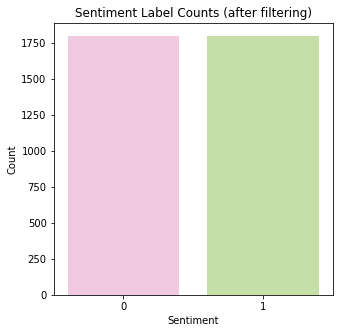

In [73]:
# bar chart to show the number of tweets tagged as Positive/Neutral/Negative
f, (ax1) = plt.subplots(1, 1, figsize=(5, 5))
sns.countplot(x="sentiment", order=[0,1], data=tweets_data_df, palette="PiYG", ax=ax1)
ax1.set_title("Sentiment Label Counts (after filtering)")
ax1.set_xlabel("Sentiment")
ax1.set_ylabel("Count")

Let's now prepare tweet text to be interpretable by our classifier. Using tools from [NLTK](https://www.nltk.org/) we first remove *stop words* which are words that do not have any important significance to be used in our classifier. Usually these words are also filtered out from search queries because they return vast amount of unnecessary information (such i.e. the, is, at, which, on, for, this, etc.). We also remove usernames, hashtags and URLs. NLTK also provides us with a tweet *tokenizer* module that splits tweet strings into a list of words. Additionally, we employ a *stemmer* to remove morphological affixes from words, leaving only the word stem (i.e.: "running" -> "run", "generously" -> "generous"). Finally, we also remove common emojis, hashtags, punctuation and numbers. 

In [74]:
from nltk.corpus   import stopwords 
from nltk.tokenize import TweetTokenizer
from nltk.stem     import PorterStemmer
import string
import re

# Set of happy emojis
emojis_happy = set([ ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
                        ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
                        '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
                        'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)','<3'])
 
# Set of sad emojis
emojis_sad = set([ ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
                      ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
                      ':c', ':{', '>:\\', ';(', '🇺🇸'])
 
# Emojis set
emojis = emojis_happy.union(emojis_sad)
 
# English stop words set
stopwords_english  = set(stopwords.words("english"))
    
# Tokenizer 
tokenizer    = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def clean_tweet(tweet):
    
    # regular expression to remove "RT" from tweets
    tweet = re.sub(r'^RT[\s]+', '', tweet)
 
    # regular expression to remove "URLs" from tweets
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # regular expression to remove "#" from tweets
    tweet = re.sub(r'#', '', tweet)
    
    # regular expression to remove "@" from tweets
    tweet = re.sub(r'@', '', tweet)
 
    # tokenize
    tweet_tokens = tokenizer.tokenize(tweet)
    
    # PorterStemmer
    stemmer = PorterStemmer()
 
    tweet_clean = []    
    for word in tweet_tokens:
        if (word not in stopwords_english and     # no stopwords
            word not in emojis and                # no emojis
            word not in string.punctuation):      # no punctuation
                stem_word = stemmer.stem(word)    # stemming word
                tweet_clean.append(stem_word)
 
    return tweet_clean

# get filtered clean words for each tweet
tweets_data_df["text"] = tweets_data_df["text"].apply(lambda x: clean_tweet(x))
# remove stopwords and punctuation
tweets_data_df

,text,sentiment
1,"[scottwalk, catch, full, gopdeb, last, night, ...",1
3,"[robgeorg, carli, fiorina, trend, hour, debat,...",1
...,...,...
13868,"[lrihendri, tedcruz, presid, alway, tell, trut...",1
13870,"[lrihendri, tedcruz, head, presidenti, debat, ...",1


## Building a sentiment classifier
First, we identify and create a dicctionary of unique words using the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) method from scikit-learn. In order to train a classifier, we need to create a vector identifying each tweet, this is called a feature vector. The vectorizer helps us to translate each word into a unique integer code, extracting the *vocabulary* in our dataset.  

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

phrases    = [' '.join(x) for x in tweets_data_df["text"].values ] # All the phrases in our tweets
vectorizer = CountVectorizer() 
vectorizer = vectorizer.fit(phrases)
print("Vocabulary size:{}".format(len(vectorizer.vocabulary_)))
print("Vocabulary content:{}".format(vectorizer.vocabulary_))

Vocabulary size:5295
Vocabulary content:{'scottwalk': 4139, 'catch': 937, 'full': 1970, 'gopdeb': 2086, 'last': 2767, 'night': 3289, 'scott': 4132, 'best': 646, 'line': 2868, '90': 197, 'second': 4157, 'walker': 5078, '16': 36, 'robgeorg': 4001, 'carli': 915, 'fiorina': 1844, 'trend': 4849, 'hour': 2316, 'debat': 1341, 'men': 3067, 'just': 2624, 'complet': 1141, 'say': 4113, 'danscavino': 1309, 'realdonaldtrump': 3833, 'deliv': 1372, 'highest': 2259, 'rate': 3809, 'histori': 2278, 'presidenti': 3675, 'trump': 4867, '2016': 68, 'gregabbott_tx': 2142, 'tedcruz': 4660, 'first': 1848, 'day': 1321, 'rescind': 3923, 'everi': 1697, 'illeg': 2375, 'execut': 1722, 'action': 266, 'taken': 4621, 'barack': 577, 'obama': 3349, 'foxnew': 1921, 'warriorwoman': 5096, '91': 199, 'like': 2857, 'happi': 2192, 'heard': 2228, 'go': 2052, 'moder': 3148, 'anymor': 433, 'megynkelli': 3058, 'nancyosborn': 3226, '180': 40, 'prove': 3734, 'batsask': 596, 'badassteachersa': 550, 'tbat': 4642, 'waynedupreeshow': 5

Using scikit-learn [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method, we now split the dataset into a training and a testing set. We define a test set about 10% of the original dataset size. 

In [76]:
# function for splitting data to train and test sets
from sklearn.model_selection import train_test_split            

# Splitting the dataset into train and test set
train, test = train_test_split(tweets_data_df,test_size = 0.1)

In [77]:
train

,text,sentiment
5737,"[mt, lessgovmorefun, american, peopl, want, pr...",1
5085,"[the_paulitician, award, disingenu, statement,...",0
...,...,...
2231,"[govmikehuckabe, washington, done, enough, lie...",1
5275,"[yaakovschapiro, thank, foxnew, bretbaier, meg...",1


In [78]:
test

,text,sentiment
5362,"[amandagutterman, wrote, slantnew, nostalgia, ...",0
9167,"[bethbehr, classi, gopdeb]",0
...,...,...
315,"[3chicspolitico, donald, trump, insult, megynk...",0
4036,"[heatherchild, god, bless, rep, parti, lot, gr...",1


Now, we need to transform tokens in each partition into a feature vectors. We will use our vectorizer to transform each tweet into a [*bag of words*](https://en.wikipedia.org/wiki/Bag-of-words_model). 

In [79]:
X_train              = [' '.join(x) for x in train['text'].values ] 
X_train_bag_of_words = vectorizer.transform(X_train)
y_train              = train['sentiment'].values.astype(int)

X_test              = [ ' '.join(x) for x in test['text'].values ] 
X_test_bag_of_words = vectorizer.transform(X_test)
y_test              = test['sentiment'].values.astype(int)

Printing instances from the training dataset after the *bag of words* transformation, we see pairs like `(0, 628)	1`. The first number identifies the phrase index (the tweet), the second number is the word code asigned by our vectorizer, finally, the las number is the count of occurrences of the word.

In [80]:
# Printing bag-of-words representation
print(X_train_bag_of_words[0])

  (0, 373)	1
  (0, 1260)	1
  (0, 2086)	1
  (0, 2828)	1
  (0, 3196)	1
  (0, 3521)	1
  (0, 3674)	1
  (0, 4177)	1
  (0, 4659)	1
  (0, 4667)	1
  (0, 4882)	1
  (0, 5088)	1


Finally, we fit Random Forest classifier model. 

In [81]:
from sklearn.ensemble import RandomForestClassifier
gnb = RandomForestClassifier(class_weight="balanced")
gnb.fit(X_train_bag_of_words.toarray(), y_train)

RandomForestClassifier(class_weight='balanced')

In [82]:
y_pred_train = gnb.predict(X_train_bag_of_words.toarray())
print("Number of mislabeled train points out of a total {} points : {}".format(X_train_bag_of_words.toarray().shape[0],(y_train != y_pred_train).sum()))
y_pred_test  = gnb.predict(X_test_bag_of_words.toarray())
print("Number of mislabeled test points out of a total {} points : {}".format(X_test_bag_of_words.toarray().shape[0],(y_test != y_pred_test).sum()))

Number of mislabeled train points out of a total 3241 points : 53
Number of mislabeled test points out of a total 361 points : 54


In [83]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report

print("Training dataset metrics")
print("Confusion matrix:\n",confusion_matrix(y_train, y_pred_train),"\n")
print("Balanced accuracy score:",balanced_accuracy_score(y_train, y_pred_train),"\n")

print("Testing dataset metrics")
print("Confusion matrix:\n",confusion_matrix(y_test, y_pred_test),"\n")
print("Balanced accuracy score:",balanced_accuracy_score(y_test, y_pred_test))
print("Full Report:\n",classification_report(y_test, y_pred_test))

Training dataset metrics
Confusion matrix:
 [[1583   36]
 [  17 1605]] 

Balanced accuracy score: 0.9836415820455153 

Testing dataset metrics
Confusion matrix:
 [[158  24]
 [ 30 149]] 

Balanced accuracy score: 0.8502670513843698
Full Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85       182
           1       0.86      0.83      0.85       179

    accuracy                           0.85       361
   macro avg       0.85      0.85      0.85       361
weighted avg       0.85      0.85      0.85       361

